In [2]:
import matplotlib.pyplot as plt
import pyopencl as cl
import numpy as np
import cv2
import cython
%matplotlib inline

In [3]:


# Get opencl devices:
plat = cl.get_platforms()
devices = plat[0].get_devices()
#print "My GPU:",devices[0]
#print "My CPU:",devices[1]

# Create contexts for my devices
#ctx_gpu = cl.Context([devices[0]])
#ctx_cpu = cl.Context([devices[1]])

#print ctx_gpu
#print ctx_cpu


In [ ]:
# OpenCL vector addition function
def opencl_vectorAdd(a, b, ctx):


    queue = cl.CommandQueue(ctx) # create a queue to schedule the kernel to run on the device

    # Create memory buffers
    mf = cl.mem_flags
    a_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
    b_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)
    dest_buf = cl.Buffer(ctx, mf.WRITE_ONLY, b.nbytes)

    # OpenCL code 
    prg = cl.Program(ctx, """
        __kernel void vectorAdd(__global float *output,
                                __global const float *in_A,
                                __global const float *in_B)
        {
            int id = get_global_id(0);        // get global thread ID
            output[id] = in_A[id] + in_B[id]; // perform vector adition
        }
        """).build()

    result = np.empty_like(a) # place to store the result
    prg.vectorAdd(queue, a.shape, None, dest_buf, a_buf, b_buf).wait() # do the vector add
    cl.enqueue_copy(queue, result, dest_buf) # copy the results from buffer into result
    #print "\nresult",result    
    return result


In [ ]:
# Python vector addition function
def py_vectorAdd(vec_a, vec_b):
    vec_c = np.zeros(len(vec_a))
    if len(vec_a) != len(vec_b):
        print "Vector A is not the same size as vector B."
        print "Vector A has length", len(vec_a),
        print "while vector B has length", len(vec_b)
    else:
        for i in range(len(vec_c)):
            vec_c[i] = vec_a[i] + vec_b[i]
    return vec_c


In [6]:
# Test 
a = np.arange(0,55,5).astype(np.float32)
b = np.arange(0,55,5).astype(np.float32)
print "Vector A:\n", a, "\nVector B:\n", b, "\nResults:"
print py_vectorAdd(a,b)
print opencl_vectorAdd(a, b, cl.Context([devices[0]]))
print opencl_vectorAdd(a, b, cl.Context([devices[1]]))


Vector A:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.] 
Vector B:
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.] 
Results:
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]


In [7]:
# Execution time comparisons:

ex_time = np.zeros(3)

sz = 5000000
a = np.random.rand(sz).astype(np.float32)
b = np.random.rand(sz).astype(np.float32)

start = cv2.getTickCount()
py_vectorAdd(a,b)
end = cv2.getTickCount()
ex_time[0] = (end - start)/ cv2.getTickFrequency()

print "\nTime taken for python vector_add:\n {0} seconds".format(ex_time[0])

#start = time.time()
#opencl_vectorAdd(a, b, ctx=ctx_gpu)
#end = time.time()
#print "Time taken for OpenCL GPU vector_add: {0} seconds".format(end - start)

#start = time.time()
#opencl_vectorAdd(a, b, ctx=ctx_cpu)
#end = time.time()
#print "Time taken for OpenCL CPU vector_add: {0} seconds".format(end - start)


for dev in range(len(devices)):
    start = cv2.getTickCount()
    opencl_vectorAdd(a, b, cl.Context([devices[dev]]))
    end = cv2.getTickCount()
    ex_time[dev+1] = (end - start)/ cv2.getTickFrequency()
    print "Time taken for OpenCL vector_add on:", str(devices[dev]).split('\'')[1], "\n {0} seconds".format(ex_time[dev+1])



Time taken for python vector_add:
 2.10372399979 seconds
Time taken for OpenCL vector_add on: Cayman 
 0.0511708316411 seconds
Time taken for OpenCL vector_add on: Intel(R) Core(TM) i7 CPU         920  @ 2.67GHz 
 0.0384221538272 seconds


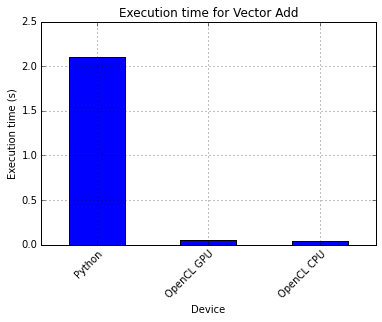

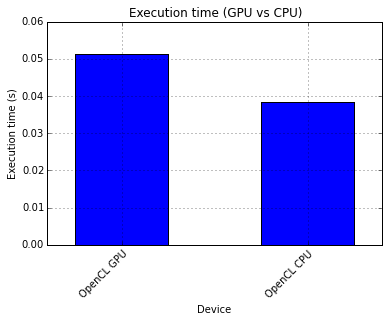

In [8]:
# Plot the data:
names = ['Python', 'OpenCL GPU', 'OpenCL CPU']
ax = plt.subplot(111)

plt.xlabel('Device')
plt.ylabel('Execution time (s)')
plt.title('Execution time for Vector Add')
plt.grid(True)
bins = map(lambda x: x-0.5/2,range(1,len(ex_time)+1))
ax.bar(bins,ex_time,0.5)
ax.set_xticks(map(lambda x: x, range(1,len(ex_time)+1)))
ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
plt.show()

# Plot the data to compare CPU to GPU:

ax = plt.subplot(111)
plt.xlabel('Device')
plt.ylabel('Execution time (s)')
plt.title('Execution time (GPU vs CPU)')
plt.grid(True)
bins = map(lambda x: x-0.5/2,range(1,len(ex_time[1:3])+1))
ax.bar(bins,ex_time[1:3],0.5)
ax.set_xticks(map(lambda x: x, range(1,len(ex_time[1:3])+1)))
ax.set_xticklabels(names[1:3],rotation=45, rotation_mode="anchor", ha="right")
plt.show()


In [9]:
sz = np.arange(10,2000000,10000)
#sz = [1,10, 100, 1000, 10000, 100000,1000000, 10000000, 50000000, 80000000 ]
dev_names = ['Python CPU', 'OpenCL GPU', 'OpenCL CPU']
py_exec_time = np.zeros(len(sz))
cpu_exec_time = np.zeros(len(sz))
gpu_exec_time = np.zeros(len(sz))
   
a = np.random.rand(max(sz)).astype(np.float32)
b = np.random.rand(max(sz)).astype(np.float32)

for i in range(len(sz)):
    start = cv2.getTickCount()
    py_vectorAdd(a[:sz[i]],b[:sz[i]])
    end = cv2.getTickCount()
    py_exec_time[i] = (end - start)/ cv2.getTickFrequency()
    
#print py_exec_time

for i in range(len(sz)):
    start = cv2.getTickCount()
    opencl_vectorAdd(a[:sz[i]],b[:sz[i]], cl.Context([devices[0]]))
    end = cv2.getTickCount()
    gpu_exec_time[i] = (end - start)/ cv2.getTickFrequency()
    
#print gpu_exec_time

for i in range(len(sz)):
    start = cv2.getTickCount()
    opencl_vectorAdd(a[:sz[i]],b[:sz[i]], cl.Context([devices[1]]))
    end = cv2.getTickCount()
    cpu_exec_time[i] = (end - start)/ cv2.getTickFrequency()

#print cpu_exec_time

In [ ]:
# Plot the data:

plt.figure(figsize=(12,8))
plt.xlabel('Vector size')
plt.ylabel('Execution time (seconds)')
plt.title('Execution time for Vector Add')
plt.grid(True)
ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")


plt.plot(sz, py_exec_time)
plt.plot(sz, gpu_exec_time)
plt.plot(sz, cpu_exec_time)

plt.legend(dev_names, loc='upper left')

plt.show()

plt.figure(figsize=(12,8))
plt.xlabel('Vector size')
plt.ylabel('Execution time (seconds)')
plt.title('Comparison between Opencl GPU and CPU')
plt.grid(True)
ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")

x = sz
#plt.plot(x, py_exec_time)
plt.plot(x, gpu_exec_time)
plt.plot(x, cpu_exec_time)

#plt.legend(dev_names[1:], loc='upper left')
plt.legend([str(devices[0]).split('\'')[1],str(devices[1]).split('\'')[1]], loc='upper left')

plt.show()